# Path Data Processing and Validation

The purpose of this notebook is to train a simple path model, hence thorough data processing and validation is needed to check for duplicates, noise, corrupted data and the sorts. The data is obtained from comma.ai [comma2k19 dataset](https://github.com/commaai/comma2k19).

In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Enable import from different directory
import sys
sys.path.insert(0, 'D:/comma2k19_dataset/notebooks/lib/')

import numpy as np
from tqdm import tqdm
import cv2
import math
import os
import scipy
from datetime import datetime
from packaging import version
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard

from tensorflow_model.efficientnet import EfficientNet

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.3.0 or above."

%pylab inline

TensorFlow version:  2.3.0
Populating the interactive namespace from numpy and matplotlib


C:\Users\brand\miniconda3\envs\carnd\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data
### Become one with the data

Data is always important, there is technically no point in training a neural network without first understanding the data. This is because noises, duplicates, mislabels and corrupted images can actually ruin the road to a SOTA model.

Inspecting the data first is very critical, this is to understand the data distribution and also look for any patterns which are human understandable so that when something goes wrong in the neural net, it will keep you sane by telling you where you should start debugging.

Ask yourself - is very local features enough or do we need global context? How much variation is there and what form does it take? What variation is spurious and could be preprocessed out? Does spatial position matter or do we want to average pool it out? How much does detail matter and how far could we afford to downsample the images? How noisy are the labels?

Once you get a qualitative sense it is also a good idea to write some simple code to search/filter/sort by whatever you can think of (e.g. type of label, size of annotations, number of annotations, etc.) and visualize their distributions and the outliers along any axis. The outliers especially almost always uncover some bugs in data quality or preprocessing.

In [2]:
BASE_PATH = 'D:/comma2k19_dataset/data_civic/'
dirs = os.listdir(BASE_PATH)
print(dirs)

['15', '30', '6']


# Path Data
The dataset consists of videos which are all 60 seconds each which is 25Hz as shown below. The path data is 2Hz. To synchronize, we will collect every 5th image for training. And for every Nth image, we will sample (N*5)th path data for a stretch of the next 100 meters. The data format obtained from the global_pose is in ECEF frame (x,y,z) and stated in meters.

In [3]:
import orientation as orient
import coordinates as coord

path = []
frame_times_list = []
frame_position_list = []
frame_orientation_list = []

for i in dirs:
    frame_times = np.load(BASE_PATH + i + '/global_pose/frame_times')
    frame_times = frame_times - frame_times[0]
    frame_positions = np.load(BASE_PATH + i + '/global_pose/frame_positions')
    frame_orientations = np.load(BASE_PATH + i + '/global_pose/frame_orientations')
    
    frame_times_list.append(frame_times)
    frame_position_list.append(frame_positions)
    frame_orientation_list.append(frame_orientations)

### Prepare the training output path data (path)
Since the data are time series input, meaning to say the data are position of the local frame at time T. Instead of time series input, we want to make them into an array of the next 100m path the vehicle should follow. To achieve that, we will look in the time series input the consecutive 100m and perform a fit function. The fit function is then validated in a graph below. In the later more comprehensive validation phase, the entire data set will be exported out for visualization.

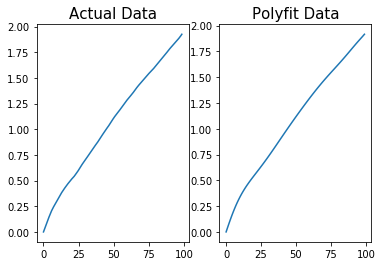

In [4]:
y_training = []
down_fit_data = []
breakpoints = []

for i in range(len(dirs)):
    
    cnt = 0    
    while True:
        ecef_from_local = orient.rot_from_quat(frame_orientation_list[i][cnt])
        local_from_ecef = ecef_from_local.T

        frame_positions_local_all = np.einsum('ij,kj->ki', local_from_ecef, frame_position_list[i][cnt:] - frame_position_list[i][cnt])
        forward = frame_positions_local_all[:,0]
        right = frame_positions_local_all[:,1]
        down = frame_positions_local_all[:,2]

        # Look for the 100th point index
        index = next((i for i,j in enumerate(forward) if j >= 100), None)
        if index == None:
            breakpoints.append(cnt)
            break

        # Polyfit a 11th degree order polynomial to the right coordinate
        coeff = np.polyfit(forward[0:index],right[0:index],11)
        ffit = np.poly1d(coeff)
        x_new = np.linspace(0,99,100)
        y_new = ffit(x_new)
        
        # Polyfit a 11th degree order polynomial to the down coordinate
        coeff = np.polyfit(forward[0:index],down[0:index],11)
        ffit = np.poly1d(coeff)
        x_new = np.linspace(0,99,100)
        z_new = ffit(x_new)

        y_training.append(y_new)
        down_fit_data.append(z_new)

        cnt += 5
    cnt = 0
    

# Evaluate the last valid path
subplot(1,2,1)
figsize(10,10);
plot(forward[0:index],right[0:index])
title('Actual Data', fontsize=15);

subplot(1,2,2)
figsize(10,10);
plot(x_new,y_new)
title('Polyfit Data', fontsize=15);

y_training = np.array(y_training)

# Image Data
The image data has to be resized to (1164,874), it is then further processed into a (6,128,256) frame_tensors as similar to comma's supercombo model input.

 86%|██████████████████████████████████████████████████████████████████▍          | 1035/1200 [00:06<00:01, 155.73it/s]


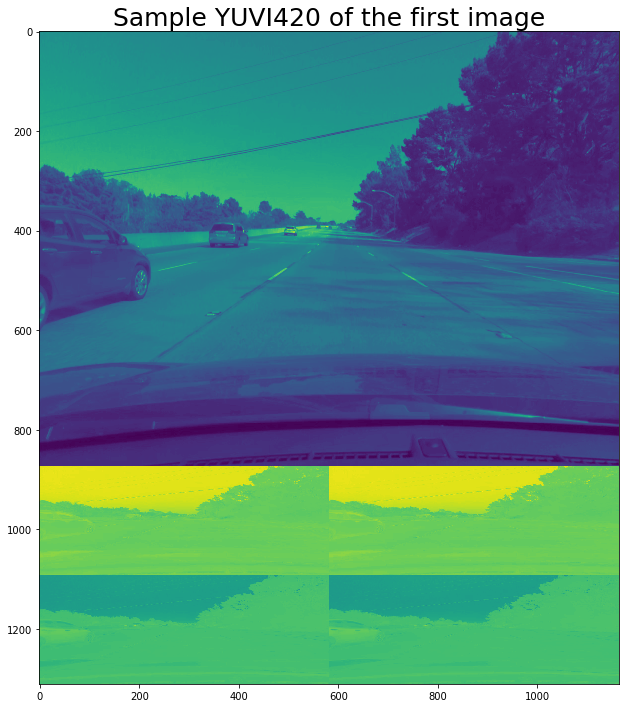

In [5]:
TOTAL_FRAMES = 1200
yuv_imgs = []

for i in range(len(dirs)):
    vid = cv2.VideoCapture(BASE_PATH + dirs[i] + '/video.hevc')
    for frame_number in tqdm(range(TOTAL_FRAMES)):
        ret, frame = vid.read()
        if (frame_number % 5 == 0):        
            frame = cv2.resize(frame,(1164,874))
            img_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV_I420)
            if frame_number == breakpoints[i]:
                break
            yuv_imgs.append(img_yuv)

        
figsize(12,12);
imshow(yuv_imgs[0]);
title('Sample YUVI420 of the first image', fontsize=25);

### Prepare the training input data
Converting the YUV_I420 images into tensors

In [6]:
from common.transformations.camera import transform_img, eon_intrinsics
from common.transformations.model import medmodel_intrinsics

def frames_to_tensor(frames):                                                                                               
    H = (frames.shape[1]*2)//3                                                                                                
    W = frames.shape[2]                                                                                                       
    in_img1 = np.zeros((frames.shape[0], 6, H//2, W//2), dtype=np.uint8)                                                      
                                                                                                                            
    in_img1[:, 0] = frames[:, 0:H:2, 0::2]                                                                                    
    in_img1[:, 1] = frames[:, 1:H:2, 0::2]                                                                                    
    in_img1[:, 2] = frames[:, 0:H:2, 1::2]                                                                                    
    in_img1[:, 3] = frames[:, 1:H:2, 1::2]                                                                                    
    in_img1[:, 4] = frames[:, H:H+H//4].reshape((-1, H//2,W//2))                                                              
    in_img1[:, 5] = frames[:, H+H//4:H+H//2].reshape((-1, H//2,W//2))
    return in_img1

imgs_med_model = np.zeros((len(yuv_imgs), 384, 512), dtype=np.uint8)
for i, img in tqdm(enumerate(yuv_imgs)):
    imgs_med_model[i] = transform_img(img, from_intr=eon_intrinsics, to_intr=medmodel_intrinsics, yuv=True,
                                    output_size=(512,256))
frame_tensors = frames_to_tensor(np.array(imgs_med_model)).astype(np.float32)/128.0 - 1.0


642it [00:09, 69.66it/s]


### Data Verification
Change the "verification_idx" to visualize any images in the dataset. It will how well the polyfit data compared to the actual data. The dark red path is the polyfitted data.

In [7]:
# Pick a frame out to visualize
verification_idx = 0

def get_dir_and_idx(idx):
    dir_idx = 0
    breakpoints_duplicate = [x//5 for x in breakpoints.copy()]
    data_idx = idx
    for i in breakpoints_duplicate:
        pt = i
        if data_idx > pt:
            data_idx -= pt
            dir_idx += 1
        else:
            break

    data_idx *= 5
    
    return data_idx, dir_idx

data_idx, dir_idx = get_dir_and_idx(verification_idx)

D:/comma2k19_dataset/notebooks/lib\camera.py:122: RuntimeWarning: divide by zero encountered in true_divide
  pt_img = pt_view/pt_view[:,2:3]
D:/comma2k19_dataset/notebooks/lib\camera.py:122: RuntimeWarning: invalid value encountered in true_divide
  pt_img = pt_view/pt_view[:,2:3]
D:/comma2k19_dataset/notebooks/lib\camera.py:93: RuntimeWarning: invalid value encountered in greater
  img_pts_denormalized[img_pts_denormalized[:,0] > W] = np.nan
D:/comma2k19_dataset/notebooks/lib\camera.py:94: RuntimeWarning: invalid value encountered in less
  img_pts_denormalized[img_pts_denormalized[:,0] < 0] = np.nan
D:/comma2k19_dataset/notebooks/lib\camera.py:95: RuntimeWarning: invalid value encountered in greater
  img_pts_denormalized[img_pts_denormalized[:,1] > H] = np.nan
D:/comma2k19_dataset/notebooks/lib\camera.py:96: RuntimeWarning: invalid value encountered in less
  img_pts_denormalized[img_pts_denormalized[:,1] < 0] = np.nan


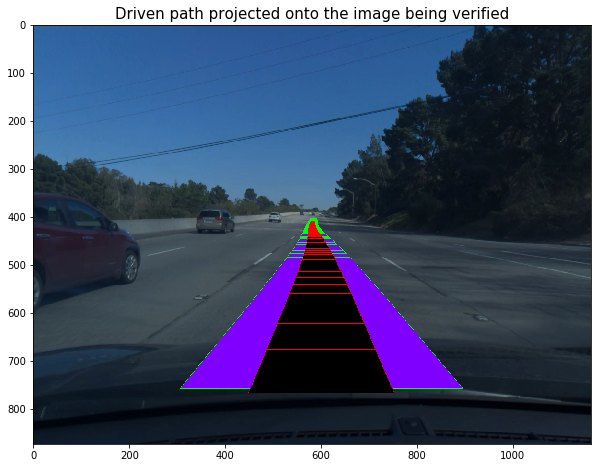

In [8]:
from camera import img_from_device, denormalize, view_frame_from_device_frame

def draw_path(device_path, img, width=1, height=1.2, fill_color=(128,0,255), line_color=(0,255,0), isTest = False):
    device_path_l = device_path + np.array([0, 0, height])                                                                    
    device_path_r = device_path + np.array([0, 0, height])  
    
    if isTest:
        width = width - 0.5
    device_path_l[:,1] -= width                                                                                               
    device_path_r[:,1] += width

    img_points_norm_l = img_from_device(device_path_l)
    img_points_norm_r = img_from_device(device_path_r)
    img_pts_l = denormalize(img_points_norm_l)
    img_pts_r = denormalize(img_points_norm_r)

    # filter out things rejected along the way
    valid = np.logical_and(np.isfinite(img_pts_l).all(axis=1), np.isfinite(img_pts_r).all(axis=1))
    img_pts_l = img_pts_l[valid].astype(int)
    img_pts_r = img_pts_r[valid].astype(int)
    
    if isTest:
        fill_color=None
        line_color=(255,0,0)

    for i in range(1, len(img_pts_l)):
        u1,v1,u2,v2 = np.append(img_pts_l[i-1], img_pts_r[i-1])
        u3,v3,u4,v4 = np.append(img_pts_l[i], img_pts_r[i])
        pts = np.array([[u1,v1],[u2,v2],[u4,v4],[u3,v3]], np.int32).reshape((-1,1,2))
        cv2.fillPoly(img,[pts],fill_color)
        cv2.polylines(img,[pts],True,line_color)

# We convert the frame_positions to the frame
# defined by the pose of the first frame
ecef_from_local = orient.rot_from_quat(frame_orientation_list[dir_idx][data_idx])
local_from_ecef = ecef_from_local.T
frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, frame_position_list[dir_idx][data_idx:data_idx+100] - frame_position_list[dir_idx][data_idx]) 

verification_img = cv2.cvtColor(yuv_imgs[verification_idx],cv2.COLOR_YUV2RGB_I420)
forward_data = np.linspace(0,99,100)
down_data = down_fit_data[verification_idx]

# Actual data
draw_path(frame_positions_local, img=verification_img)
# Training data (polyfit data)
draw_path(np.column_stack([forward_data,y_training[verification_idx],down_data]), img=verification_img, isTest = True)


figsize(10,10);
imshow(verification_img);
title('Driven path projected onto the image being verified', fontsize=15);

### Make sure that all the data is clean, with no outliers or noise
Export all of the data into a folder and look for any anomalies within the data.

In [9]:
verification_folder = "verification_folder"
# Get the length of the data
data_length = len(yuv_imgs)
error_idx = []

for i in tqdm(range(data_length)):
    data_idx, dir_idx = get_dir_and_idx(i)
    
    # We convert the frame_positions to the frame
    # defined by the pose of the first frame
    ecef_from_local = orient.rot_from_quat(frame_orientation_list[dir_idx][data_idx])
    local_from_ecef = ecef_from_local.T
    frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, frame_position_list[dir_idx][data_idx:data_idx+100] - frame_position_list[dir_idx][data_idx]) 

    verification_img = cv2.cvtColor(yuv_imgs[i],cv2.COLOR_YUV2BGR_I420)
    forward_data = np.linspace(0,99,100)
    down_data = down_fit_data[i]
    
    # Training data (polyfit data)
    try:
        draw_path(np.transpose([forward_data,y_training[i],down_data]), img=verification_img, isTest = True)
    except IndexError:
        print("[ERROR] at index " + str(i))
        error_idx.append(i)
        
    cv2.imwrite(os.path.join(verification_folder , str(i) + '.jpg'), verification_img)  

for err in error_idx:
    frame_tensors = np.delete(frame_tensors,err,0)
    yuv_imgs.pop(err)
    y_training = np.delete(y_training,err,0)

100%|████████████████████████████████████████████████████████████████████████████████| 642/642 [00:23<00:00, 27.47it/s]


### Manually remove lane change data by visualising the verified data in the verification_folder
Go into the verification_folder and look for any corrupted data, note the filename and insert the number into the manual_idx below.

In [10]:
manual_idx = [x for x in range(30)]

for err in manual_idx:
    frame_tensors = np.delete(frame_tensors,err,0)
    yuv_imgs.pop(err)
    y_training = np.delete(y_training,err,0)

### Save all the training data into a file
Save all the data into a npy numpy format so we could extract out again to be used by many different training models.

In [11]:
file_save_path = "training_data/baseline_batch"

# Save the input as input and output as output
np.save(os.path.join(file_save_path , "output"), y_training)
np.save(os.path.join(file_save_path , "input"), frame_tensors)

### Summary of the data

The frame_tensors/input has the shape of (612, 6, 128, 256)
The path/output has the shape of (612, 100)
The mean of the data is 1.465186217438533


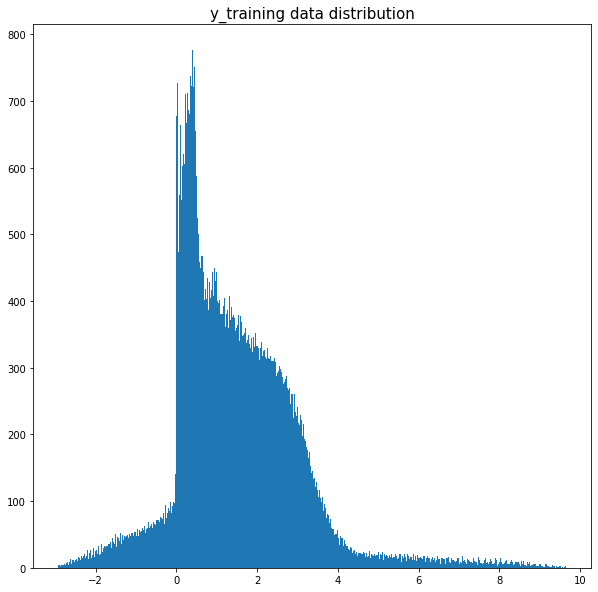

In [29]:
import matplotlib.pyplot as plt

print("The frame_tensors/input has the shape of " + str(shape(frame_tensors)))
print("The path/output has the shape of " + str(shape(y_training)))

# Reshape the output tensor to see the distribution of data so we can init and set the final layer bias
hist_data = y_training.copy()
hist_data = np.reshape(hist_data,size(y_training))

print("The mean of the data is " + str(np.mean(hist_data)))

figsize(10,10);
plt.hist(hist_data, 500)
title('y_training data distribution', fontsize=15);

verification_folder = "validation"
# Get the length of the data
data_length = len(test_train)
error_idx = []

for i in tqdm(range(data_length)):
    data_idx, dir_idx = get_dir_and_idx(i)
    
    verification_img = cv2.cvtColor(yuv_imgs[i],cv2.COLOR_YUV2BGR_I420)
    forward_data = np.linspace(0,99,100)
    down_data = down_fit_data[i]
    
    # Training data (polyfit data)
    try:
        draw_path(np.transpose([forward_data,test_train[i],down_data]), img=verification_img, isTest = True)
    except IndexError:
        print("[ERROR] at index " + str(i))
        error_idx.append(i)
        
    cv2.imwrite(os.path.join(verification_folder , str(i) + '.jpg'), verification_img)  